We extract video frames from selected animations and extract
the line art images to form our training dataset. We calculate a
**768-dimensional feature vector of histograms of R, G, B channels
for each frame**. The difference between frames is determined by
calculating the **mean square error** of the feature vectors, which
is used for splitting the source animations into shots. When the
difference between the neighboring frames is **greater than 200**, it
is considered to belong to different shots. In order to improve the
quality of the data, we **remove shots in which the mean square
errors between all pairs of frames are less than 10** (as they are
too uniform), and **the shot with a length less than 8 frames**.
Then we **filter out video frames that are too dark or too faded
in color**. Finally we get a total of 
1096 video sequences from 6 animations, with a total of 29,834 images. 
Each video sequence
has 27 frames on average. 

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import json
import os
import shutil
import pandas as pd
from skimage.metrics import structural_similarity


Let's create the frames.

In [14]:
def VidToFrames_2 (vidpath, folderName):
    vidcap = cv2.VideoCapture(vidpath)
    success,image = vidcap.read()
    count = 0
    length = int(vidcap.get(cv2.CAP_PROP_FPS))
    width  = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(length, width, height)
    while success:
        resized = cv2.resize(image, (256,256), interpolation = cv2.INTER_AREA)
        cv2.imwrite("{}/{}.png".format(folderName, str(count).zfill(5)), resized)  
        success,image = vidcap.read()
        count += 1
    print(count, "frames in file")

def VidToFrames (vidpath, folderName):
    vidcap = cv2.VideoCapture(vidpath)
    success,image = vidcap.read()
    print(success)
    count = 0
    length = int(vidcap.get(cv2.CAP_PROP_FPS))
    width  = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(length, width, height)
    while success:
        cv2.imwrite("{foldername}/{frameNum}.png".format(foldername= folderName, frameNum=str(count)), image)  
        success,image = vidcap.read()
        count += 1
    print(count, "frames in file")

# for i in glob.glob("mp4/*.mp4")[1:]:
#     print(i)
#     destination = i.split('.mp4')[0].split('-',1)[-1]
#     os.mkdir(destination)
#     VidToFrames_2(i, destination)

mp4/berdnite-Hkz0NcKPzMs.mp4
30 640 360
2087 frames in file
mp4/Scale of Things in Minecraft (UPDATED VERSION in the description!)-iRBmUQQzpWQ.mp4
30 640 360
6052 frames in file
mp4/Private School-IwxWmKsVR5U.mp4
29 640 360
11453 frames in file
mp4/I have APHANTASIA (and you may too...without realising it!)-ewsGmhAjjjI.mp4
24 640 360
18566 frames in file
mp4/Being a Boba Barista (Work Stories)-so1_5hYUEE8.mp4
29 640 360
9584 frames in file
mp4/20 ART STYLES CHALLENGE!!! _ Melanie Martinez-6wS_uON5s6Q.mp4
29 640 360
28670 frames in file
mp4/'just buy a new one'-hpQQohcHk9Q.mp4
24 640 360
312 frames in file
mp4/How KSI Saved Logan Paul's Career-gA0bi-bFEYs.mp4
23 640 360
9779 frames in file
mp4/Arizona Adventure! (ft. TheOdd1sOut)-uDvPIKM-L1o.mp4
29 640 360
21516 frames in file
mp4/Actually, I Quit DanPlan-RlU32AfEVeU.mp4
29 640 360
12786 frames in file
mp4/Being Mute for 3 Years-F8A-tXp09fs.mp4
29 640 360
20136 frames in file
mp4/The Kindergarten Disstrack-18msRdBF11A.mp4
29 640 360
104

Now that we have folders with frames from each video for each channelId, we can start the analysis. There is two parts to this: 
1. Color analysis
2. Motion analysis

### Part I  <br/>
***Color Analysis*** <br/>
Is there a correlation between color and subcount?

In [41]:
def binAndPlot(some_list):
    sorted_list = sorted(some_list)
    sorted_counted = Counter(sorted_list)
    range_length = list(range(int(max(some_list)+1))) # Get the largest value to get the range.
    data_series = {}

    for i in range_length:
        data_series[i] = 0 # Initialize series so that we have a template and we just have to fill in the values.
    for key, value in sorted_counted.items():
        data_series[key] = value
    data_series = pd.Series(data_series)
    x_values = data_series.index
    plt.hist(some_list, edgecolor="yellow", color="green")
    plt.show()

### Part 2:
*** Motion Analysis ***

Is there a correlation between the amount of animation and subcount?

In my head, I should technically analyze how much each frame differs from each other. 
However, color is a value that is assigned to each pixel in a frame.

So we are going to get rid of color. We're not completely getting rid of it tho- any changes due to color will be detected (example)- because we are using
ahem ahem an eXtended difference-of-Gaussians to extract the lines. So we're basically changing the data to put less weight on color because it's already been accounted for in Part I.

 There was a time when I was interested in colorization machine learning techniques. Honestly, I still am, just less than this project. 

 There was a paper called [Deep Line Art Video Colorization with a Few References](https://arxiv.org/abs/2003.10685) that I spent some time generating data for. It was only after I generated all the data that I realized I don't have the resources (GPU, money, honestly, motivation was the biggest factor)

> We extract video frames from selected animations and extract
the line art images to form our training dataset. We calculate a
768-dimensional feature vector of histograms of R, G, B channels
for each frame. The difference between frames is determined by
calculating the mean square error of the feature vectors, which
is used for splitting the source animations into shots. When the
difference between the neighboring frames is greater than 200, it
is considered to belong to different shots. In order to improve the
quality of the data, we remove shots in which the mean square
errors between all pairs of frames are less than 10 (as they are
too uniform), and the shot with a length less than 8 frames.
Then we filter out video frames that are too dark or too faded
in color. Finally we get a total of 1096 video sequences from 6
animations, with a total of 29,834 images. Each video sequence
has 27 frames on average. 

In my case, I got around 28k iumages with 32 frames per scene on average.

I'm going to use the data collection method stated above, with a slight variation


In [22]:
with open('../channelId_to_mostViewedVidId.json', 'r') as j:
    channelId_to_mostViewedVidId = json.loads(j.read())

LIST_OF_CHANNEL_IDS= channelId_to_mostViewedVidId.keys()
print(len(LIST_OF_CHANNEL_IDS))
channelId_to_mostViewedVidId

62


{'UCsDmESjqNPukDmVnuneLrqw': 'EcgkRp2IUsc',
 'UCY6Ij8zOds0WJEeqCLOnqOQ': 'kbCah6yhYRs',
 'UClN24S5-fc7LD0JJW0FdGWw': 'ewsGmhAjjjI',
 'UC3iNdSV_RQU7DHTGpqEW96w': 'gA0bi-bFEYs',
 'UC_52i6mlrzOZs_NEuSepzAg': 'so1_5hYUEE8',
 'UCr3cBLTYmIK9kY0F_OdFWFQ': 'xa-4IAR_9Yw',
 'UCV6g95OBbVtFmN9uiJzkFqQ': 'I9uWUw1fxOY',
 'UCgCKYs56-LKEPGQ99DzqQOg': 'W8P5ewPk9fM',
 'UCOwxx9VnEnlFKt5EB70KTzQ': '12Ne9n40tmw',
 'UC2Ds30pkifFVD0CE08wF50g': 'Mv8OkBjySGQ',
 'UC7UGbBVrqLlq6CRxWWUmyKw': '2juKkLxdQo0',
 'UCn1XB-jvmd9fXMzhiA6IR0w': 'eNGgfPs0Xp8',
 'UCFeqAfEuKm7lIg2ddQzh61A': 'rlSXaDq3uOk',
 'UCAlxwHEm1bWWYoe5VCSQYEg': 'Vm6Yu2N-ePI',
 'UCz7iJPVTBGX6DNO1RNI2Fcg': '0Vxp_Lj2b-E',
 'UCOAUz4d1NUNxSHh_SOJtdGQ': '5pMckBGWzAY',
 'UCGGTAB19HlHEWPwwmxHsEKA': 'de8PRd_d7kg',
 'UCOsATJw-IZgqGT8MFrHjKGg': 'oKLbOxLJfRg',
 'UCsKVP_4zQ877TEiH_Ih5yDQ': 'Y7lYeRqhQ9Q',
 'UCOinp9hALPUcZeoL3Kmaviw': 'BErOLQBZ6c8',
 'UCGwu0nbY2wSkW8N-cghnLpA': 'plSyrHqUh78',
 'UCu6v4AdYxVH5fhfq9mi5llA': 'o0zjRGRYEhk',
 'UCj74rJ9Lgl3WTngq675wxKg': 'hp

In [21]:
with open('../masterSheetOfChannelIdToListOfVidInfos.json', 'r') as j:
    masterSheet = json.loads(j.read())

channelId_to_mostViewedVidInfo = {}

for channelId in LIST_OF_CHANNEL_IDS:
    mostViewedVidId = channelId_to_mostViewedVidId[channelId]
    for vidInfo in masterSheet[channelId]:
        if vidInfo['vidId'] == mostViewedVidId:
            channelId_to_mostViewedVidInfo[channelId] = vidInfo
channelId_to_mostViewedVidInfo
# print(len(channelId_to_mostViewedVidId))

{'UCsDmESjqNPukDmVnuneLrqw': {'vidId': 'EcgkRp2IUsc',
  'publishTime': '2017-10-26T01:05:22Z',
  'vidTitle': 'My Hot Babysitter Got Me In Trouble',
  'duration': 'PT6M30S',
  'viewCount': 35960829,
  'likeCount': 840561,
  'commentCount': 75550,
  'topicCategories': ['https://en.wikipedia.org/wiki/Entertainment',
   'https://en.wikipedia.org/wiki/Film'],
  'description': "First Name Babysitter. Last Name Trouble. \nGET T-SHIRTS: http://www.itsalexclark.com \nSEE ME ON TOUR: http://www.itsalexclark.com/tour\n\nThanks to Shgurr and PamonSunset:\nhttps://www.youtube.com/channel/UCkQ3eqNNaFrBZ_WbnCIMN8w\n\nSubscribe: http://bit.ly/SubAlexClark | Get ItsAlexClark merch: http://itsalexclark.bigcartel.com/ \nWatch my latest video: https://youtube.com/watch?v=YIiBGDBN-Po&list=PLmh1WGagp73Jbndkw6nCz2JCm73jEp8gh\nHelp out the channel: https://Patreon.com/itsalexclark\n\nFollow ItsAlexClark!\nFacebook: https://facebook.com/itsalexclark/?ref=br_rs\nInstagram: https://instagram.com/itsalexclark/\nT

In [19]:
import regex as re
channelId_to_mostViewedVidInfo = pandas.DataFrame.from_dict(channelId_to_mostViewedVidInfo).T
not_candidate_vidIds= ['kQEtRoyFfI8', 'hpQQohcHk9Q', '6wS_uON5s6Q', 'RlU32AfEVeU', 'iVqhzEaJhDw', 'Xnv7JGqjaAo', '18msRdBF11A', 'Ln4AnsWNUQI', 'Hkz0NcKPzMs']

#https://en.wikipedia.org/wiki/ISO_8601#Durations
for channelId, row in df.iterrows():
    x= row['duration']
    m=0
    s=0
    try:
        m, s = re.findall('PT(\d+)M(\d+)S',x)[0]
    except:
        s = re.findall('PT(\d+)S',x)[0]
    if int(m)*60+int(s) < 210:
        not_candidate_vidIds.append(row['vidId'])
not_candidate_vidIds = set(not_candidate_vidIds)
candidateVideos = list(set(df.vidId)- not_candidate_vidIds)
channelId_to_mostViewedVidInfoDf = df[df.vidId.isin(candidateVideos)]
print(len(channelId_to_mostViewedVidInfoDf))
channelId_to_mostViewedVidInfoDf

NameError: name 'channelId_to_mostViewedVidInfo' is not defined

Get lineart for all frames

couple that do not fit the criteria:: vidIds [kQEtRoyFfI8- gameplay, hpQQohcHk9Q- too short. not commentary, 6wS_uON5s6Q- speeddrawing, RlU32AfEVeU- footage apparently from another youtuber, iVqhzEaJhDw- too short, Xnv7JGqjaAo- speeddraw, iRBmUQQzpWQ- simply not animation, 18msRdBF11A- not animation, Ln4AnsWNUQI- not animation, Hkz0NcKPzMs- too short]



The plan is to find the distribution of DIFF. It'll vary based on the artist.

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from IPython.display import Image, display

dictOfVidIdToDiffMse = {}

def getFeatureVectorOfImage_color (imagePath):
    image = cv2.imread(imagePath)
    vectors = []
    for i, col in enumerate(['b', 'g', 'r']):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        vectors.append(hist)
        # plt.plot(hist, color = col)
        # plt.xlim([0, 256])
    # plt.show()
    vectors = np.vstack(vectors)
    return vectors

def getFeatureVectorOfImage (imagePath):
    image = cv2.imread(imagePath)
    vectors = []
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    vectors = np.vstack(hist)
    return vectors

def MSE_images (vA, vB):
    return np.sum(np.square(np.subtract(vA, vB)))

def DIFF_images(vA, vB):
    return (np.abs(vA - vB)).mean()

#https://ece.uwaterloo.ca/~z70wang/publications/ssim.pdf
def removeLowDiff_andDemo(folderName):
    vidId = folderName.split('/')[-1]
    print(">", folderName)
    frameList = glob.glob(folderName+'/*.png') #unfortunately, doesn't work bc sortByInt isn't a thing
    validFiles = 0 
    validFrameList = []

    lowRangeDone= False
    midRangeDone= False
    highRangeDone= False

    listOfMSE = []
    listOfDIFF = []
    listOfSIMM=[]

    imageShape = cv2.imread(frameList[0]).shape
    h,w,c = imageShape
    for i in range(len(frameList)-1):
        firstFrame = '{}/{}.png'.format(folderName, str(i).zfill(5))
        secondFrame = '{}/{}.png'.format(folderName, str(i+1).zfill(5))
        (score, _) = structural_similarity(cv2.cvtColor(cv2.imread(firstFrame), cv2.COLOR_BGR2GRAY), cv2.cvtColor(cv2.imread(secondFrame), cv2.COLOR_BGR2GRAY), full=True)
        listOfSIMM.append(score)
        if (score < 0.99):
            validFrameList.append(firstFrame)
            validFiles+=1
        # if (lowRangeDone and midRangeDone and highRangeDone) == False:
        #     if (score >= 0.9 and not lowRangeDone):
        #         print ("low diff = : ", score)
        #         print(firstFrame)
        #         display(Image(filename=firstFrame))
        #         print (secondFrame)
        #         display(Image(filename=secondFrame))
        #         lowRangeDone = True
        #     if (score > 0.6 and score < 0.9  and not midRangeDone):
        #         print ("mid diff = : ", score)
        #         print(firstFrame)
        #         display(Image(filename=firstFrame))
        #         print (secondFrame)
        #         display(Image(filename=secondFrame))
        #         midRangeDone = True
        #     if (score <= 0.6  and not highRangeDone):
        #         print ("high diff = : ", score)
        #         print(firstFrame)
        #         display(Image(filename=firstFrame))
        #         print (secondFrame)
        #         display(Image(filename=secondFrame))
        #         highRangeDone = True
    binAndPlot(listOfSIMM)

    mean = np.mean([i for i in listOfSIMM])
    std = np.std([i for i in listOfSIMM])
    stdList = [std*-3.5+mean, std*-3+mean, std*-2.5+mean, std*-2+mean, std*-1+mean, std*-0.5+mean, mean, std*.5+mean, std+mean, std*1.5+mean, std*2+mean, std*2.5+mean, std*3+mean, std*3.5+mean]
    dictOfVidIdToDiffMse[vidId] = {'validityRatio': validFiles/len(frameList), 'scoreMin': str(np.amin([i for i in listOfSIMM])), 'stdList': stdList,
    'scoreMax': str(np.amax([i for i in listOfSIMM])), 'scoreMean': str(np.mean([i for i in listOfSIMM])), 'scoreStd': str(np.std([i for i in listOfSIMM])), 'scoreVar': str(np.var([i for i in listOfSIMM]))}

    # dictOfVidIdToDiffMse[vidId] = {'numOfFrames': len(frameList), 'validityRatio': validFrameList/len(frameList), 'diffMin': str(np.amin(listOfDIFF)), 'diffMax': str(np.amax(listOfDIFF)), 'diffMean': str(np.mean(listOfDIFF)), 'diffVar': str(np.var(listOfDIFF)),
    #                                 'mseMin': str(np.amin(listOfMSE)), 'mseMax': str(np.amax(listOfMSE)), 'mseMean': str(np.mean(listOfMSE)), 'mseVar': str(np.var(listOfMSE))}
    return validFrameList
            

for lineartPath in glob.glob("frames/*"):
    if lineartPath.split('/')[-1] not in not_candidate_vidIds:
        removeLowDiffDst = removeLowDiff_andDemo(lineartPath)

In [4]:
# with open('vidIdToFramesListAndStats.json', 'w') as output:
#     json.dump(dictOfVidIdToDiffMse, output)
with open('vidIdToFramesListAndStats.json') as input:
    data = json.load(input)

In [54]:
vidIdToFramesListAndStatsDf = pandas.DataFrame.from_dict(data).T


with open('../channelId_to_mostViewedVidId.json') as input:
    channelId_to_mostViewedVidId = json.load(input)
with open('../channelHolisticInfo.json') as input:
    channelHolisticInfo = pandas.DataFrame.from_dict(json.load(input))

channelIdInOrder = []
for index in vidIdToFramesListAndStatsDf.index:
    for channelId, mostViewedVidId in channelId_to_mostViewedVidId.items():
        if index == mostViewedVidId:
            channelIdInOrder.append(channelId)

channelTitle=[]
channelSubCountNormalized=[]
for channelId in channelIdInOrder:
    for index, row in channelHolisticInfo.iterrows():
        if row['channelId'] == channelId:
            channelTitle.append(row['channelName'])
            channelSubCountNormalized.append(row['subscribersPerYearSinceFirstUpload'])
channelHolisticInfo.head()
vidIdToFramesListAndStatsDf['channelId'] = channelIdInOrder
vidIdToFramesListAndStatsDf['channelName'] = channelTitle
vidIdToFramesListAndStatsDf['subscribersPerYearSinceFirstUploadChannelName'] = channelSubCountNormalized
vidIdToFramesListAndStatsDf.head()

,validityRatio,scoreMin,stdList,scoreMax,scoreMean,scoreStd,scoreVar,channelId,channelName,subscribersPerYearSinceFirstUploadChannelName
Mv8OkBjySGQ,0.379548,8.672938723599157e-05,"[0.5436172759273339, 0.6005824194012843, 0.657...",1.0,0.9423732802449869,0.11393028694790087,0.012980110284031033,UC2Ds30pkifFVD0CE08wF50g,Daidus,2.892382e+05
2yFCyPX3kT0,0.135283,0.03059267673379751,"[0.7022844200010276, 0.7418648163216981, 0.781...",1.0,0.979347194245721,0.07916079264134097,0.006266431091605384,UCo8bcnLyZH8tBIH9V1mLgqQ,TheOdd1sOut,2.376871e+06
OyDLuom4KGs,0.260959,0.0008279107896865053,"[0.6312639381203012, 0.6789874587345693, 0.726...",1.0,0.965328582420178,0.09544704122853623,0.009110137679281894,UC2hm5rD_IrfYRMfq5YQudgA,Haminations,4.046380e+05
2juKkLxdQo0,0.054485,0.0007255067131991104,"[0.7601628928603037, 0.7929499145799914, 0.825...",1.0,0.9896720448981174,0.06557404343937535,0.004299955172989085,UC7UGbBVrqLlq6CRxWWUmyKw,DanPlan,2.756757e+05
uDvPIKM-L1o,0.46068,0.00011267514648194952,"[0.43222473506495396, 0.5038456463457026, 0.57...",1.0,0.9335711140301945,0.1432418225614973,0.020518219730739484,UCP21EOiKAkCGjv6kqS6UsZw,LukeOrSomething,4.303323e+04


In [9]:
%matplotlib widget

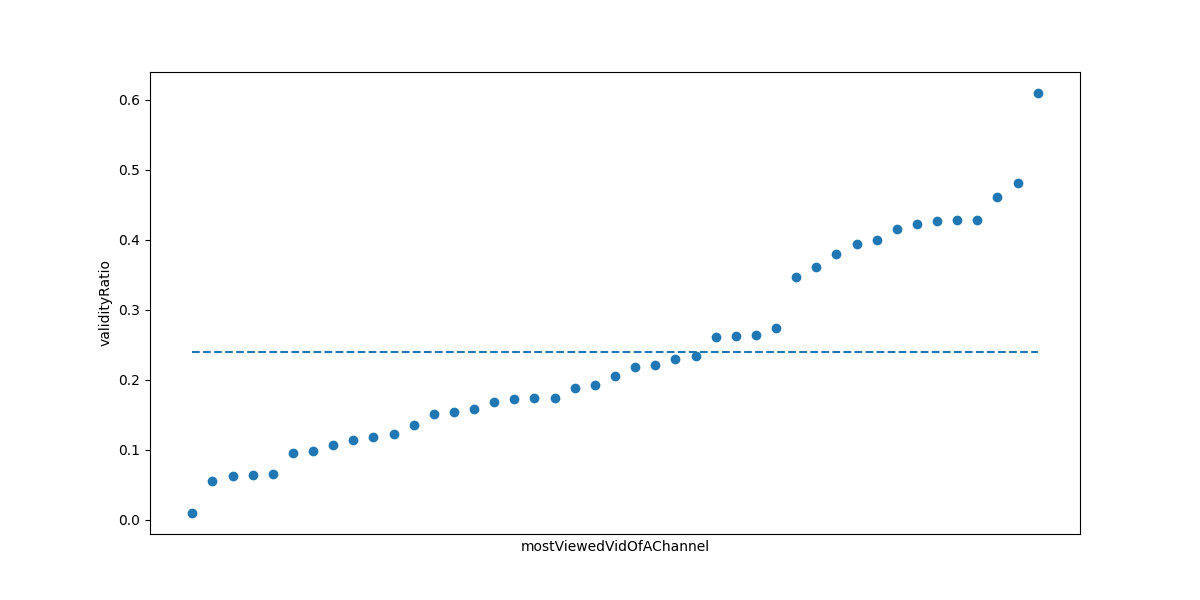

In [34]:
import mplcursors

x_name = "mostViewedVidOfAChannel"
y_name = "validityRatio"
tooltip_name = "channel owner"

zipped = zip(vidIdToFramesListAndStatsDf.index, vidIdToFramesListAndStatsDf[y_name])
sorted_vidId_to_validRatio = dict(sorted(dict(zipped).items(), key=lambda item: item[1]))

# tt = df[tooltip_name]

fig, ax = plt.subplots(1, figsize=(12,6))
sc = ax.scatter(sorted_vidId_to_validRatio.keys(), sorted_vidId_to_validRatio.values())
# Plot the average line
avg_score= vidIdToFramesListAndStatsDf[y_name].mean()
mean_x=np.arange(0,43,1)
mean_y=[avg_score for i in np.zeros_like(x)]
mean_line = ax.plot(mean_x,mean_y, label='Mean', linestyle='--')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
cursor = mplcursors.cursor(sc, hover=True)

plt.xlabel(x_name)
plt.ylabel(y_name)
plt.show()

float64 float64


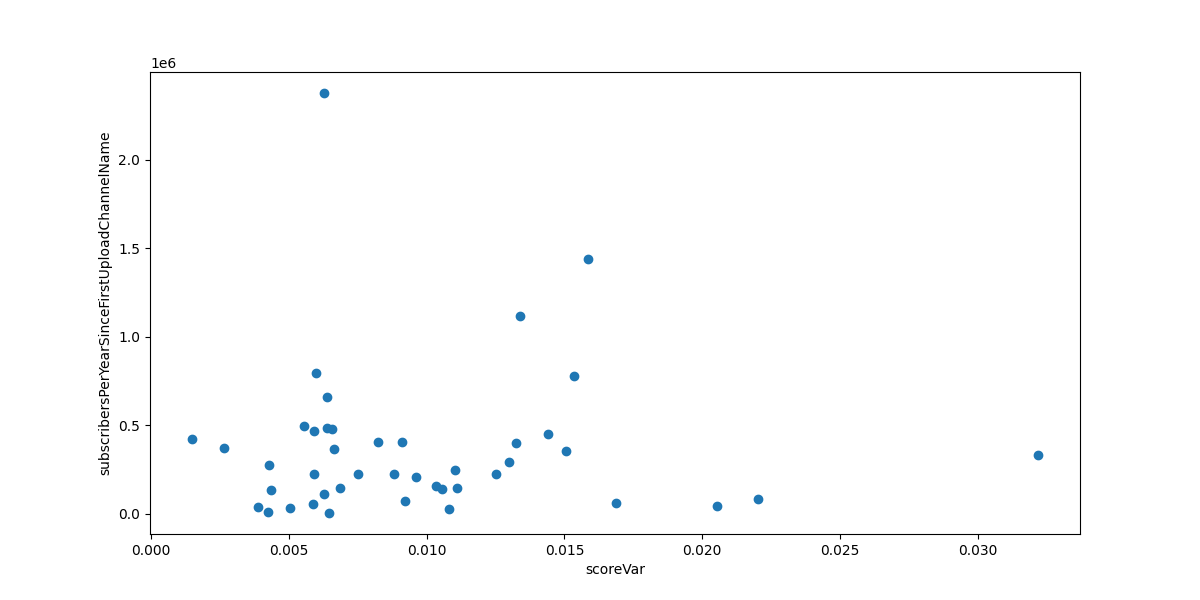

0.007695803571522201


In [72]:
import numpy as np
import scipy.stats

def generate_plot(vidIdToFramesListAndStatsDf):
    x_name = "scoreMean"
    y_name = "subscribersPerYearSinceFirstUploadChannelName"
    tooltip_name = "channelName"
    x= vidIdToFramesListAndStatsDf[x_name].astype(float, errors = 'raise')
    y= vidIdToFramesListAndStatsDf[y_name]
    print(x.dtype,y.dtype)


    tt = vidIdToFramesListAndStatsDf[tooltip_name]
    fig, ax = plt.subplots(1, figsize=(12,6))
    sc = ax.scatter(x, y)

    annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(details):
        pos = sc.get_offsets()[details["channelName"]]
        annot.xy = pos
        text = "{}, {}".format(" ".join(details["channelName"]), 
                            " ".join([details[x_name]]))
        annot.set_text(text)
        annot.get_bbox_patch().set_alpha(0.4)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, details = sc.contains(event)
            if cont:
                update_annot(details)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()
    cursor = mplcursors.cursor(sc, hover=True)
    cursor.connect(
    "add", lambda sel: sel.annotation.set_text(tt[sel.index]))
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()

    m, b = np.polyfit(x,y, 1)
    plt.plot(x, m*x + b)
    result = scipy.stats.linregress(x, y)
    print(result.rvalue)

generate_plot(vidIdToFramesListAndStatsDf)

In [71]:
import numpy as np
import pandas as pd
def detect_outlier(data_1):
    outliers=[]
    # threshold=3 means any data with a stdDev> 3 or <-3 is 0.3 of all data. Almost all of the data (99.7%) should be within 3 stddev from the mean
    threshold=3
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    
    index =0
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append((index, y))
        index+=1
    return outliers
x_name = "validityRatio"
y_name = "subscribersPerYearSinceFirstUploadChannelName"
x= vidIdToFramesListAndStatsDf[x_name].astype(float, errors = 'raise')
y= vidIdToFramesListAndStatsDf[y_name]
    
print("validityRatio outlier:", detect_outlier(x))
print("subs outlier:", detect_outlier(y))

validityRatio outlier: []
subs outlier: [(1, 2376871.2574850298)]
